# 06_macro_sessions.ipynb
## Transform Raw Events into Macro-Session Panel Dataset

This notebook implements the core sessionization logic to transform raw event streams into a structured panel dataset.

### Key Features:
- Purchase-anchored session identification with 7-day lookback
- Abandoned session detection via gap analysis
- Temporal feature engineering with strict causal boundaries
- Efficient processing using Polars for 26M+ events

In [76]:
import polars as pl
import pandas as pd
import numpy as np
from pathlib import Path
from datetime import datetime, timedelta
import json
import gc
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Initialize timing
start_time = datetime.now()
print(f"Script started at: {start_time}")

Script started at: 2025-09-24 09:44:44.047999


## 1. Configuration

In [77]:
# ===== CONFIGURATION =====
# All key parameters for the sessionization and feature engineering process

# Session Definition Parameters
SESSION_GAP_DAYS = 3  # New session starts after 3 days of user inactivity
                      # This captures natural shopping episode boundaries

# Prior History Window
PRIOR_USER_HISTORY_DAYS = 30  # Days of user history to calculate before each session
                              # Used for control variables (prior purchases, clicks, etc.)

# Data Quality Parameters
WINSORIZE_PERCENTILE = 99  # Cap extreme values at this percentile
                           # Applied to duration and intensity metrics

# Paths
DATA_DIR = Path('./data')
OUTPUT_FILE = DATA_DIR / 'analytical_panel_dataset.parquet'
METADATA_FILE = DATA_DIR / 'analytical_panel_metadata.json'

print("="*60)
print("CONFIGURATION SUMMARY")
print("="*60)
print(f"Session Definition:")
print(f"  Inactivity gap threshold: {SESSION_GAP_DAYS} days")
print(f"  Prior history window: {PRIOR_USER_HISTORY_DAYS} days")
print(f"\nData Quality:")
print(f"  Winsorizing at: {WINSORIZE_PERCENTILE}th percentile")
print(f"\nOutput:")
print(f"  Dataset: {OUTPUT_FILE}")
print(f"  Metadata: {METADATA_FILE}")
print("\nApproach: Adaptive window sessionization")
print("Sessions defined by user activity gaps, with comprehensive")
print("intensity controls to isolate causal effects.")

CONFIGURATION SUMMARY
Session Definition:
  Inactivity gap threshold: 3 days
  Prior history window: 30 days

Data Quality:
  Winsorizing at: 99th percentile

Output:
  Dataset: data/analytical_panel_dataset.parquet
  Metadata: data/analytical_panel_metadata.json

Approach: Adaptive window sessionization
Sessions defined by user activity gaps, with comprehensive
intensity controls to isolate causal effects.


In [78]:
print("\n" + "="*80)
print("PHASE 1: DATA LOADING")
print("="*80)

# Load metadata
metadata_path = DATA_DIR / 'metadata_365d.json'
with open(metadata_path, 'r') as f:
    metadata = json.load(f)

print(f"\nLoading data from extraction: {metadata['timestamp']}")
print(f"Period: {metadata['analysis_start_date']} to {metadata['analysis_end_date']}")

# Load all parquet files using Polars for efficiency
data_files = {
    'auctions_users': 'auctions_users_365d.parquet',
    'auctions_results': 'auctions_results_365d.parquet',
    'impressions': 'impressions_365d.parquet',
    'clicks': 'clicks_365d.parquet',
    'purchases': 'purchases_365d.parquet',
    'catalog': 'catalog_365d.parquet'
}

data = {}
for name, filename in tqdm(data_files.items(), desc="Loading data files"):
    filepath = DATA_DIR / filename
    data[name] = pl.read_parquet(filepath)
    print(f"  {name}: {data[name].height:,} rows loaded")


PHASE 1: DATA LOADING

Loading data from extraction: 20250923_194119
Period: 2024-09-02 to 2025-09-02


Loading data files:   0%|          | 0/6 [00:00<?, ?it/s]

  auctions_users: 657,597 rows loaded


Loading data files:  33%|███▎      | 2/6 [00:06<00:12,  3.08s/it]

  auctions_results: 26,362,985 rows loaded


Loading data files:  50%|█████     | 3/6 [00:08<00:07,  2.62s/it]

  impressions: 2,459,435 rows loaded
  clicks: 79,031 rows loaded
  purchases: 11,215 rows loaded


Loading data files: 100%|██████████| 6/6 [00:18<00:00,  3.07s/it]

  catalog: 6,842,400 rows loaded


## 3. Create Unified Event Stream

In [79]:
print("\n" + "="*80)
print("PHASE 2: CREATE UNIFIED EVENT STREAM")
print("="*80)

events_list = []

# Process auctions
print("\nProcessing auctions...")
auctions_events = data['auctions_users'].select([
    pl.col('user_id'),
    pl.col('created_at').alias('timestamp'),
    pl.lit('auction').alias('event_type'),
    pl.col('auction_id'),
    pl.lit(None).cast(pl.Utf8).alias('product_id'),
    pl.lit(None).cast(pl.Utf8).alias('vendor_id'),
    pl.lit(None).cast(pl.Utf8).alias('purchase_id'),
    pl.lit(0).cast(pl.Int64).alias('revenue')
])
events_list.append(auctions_events)

# Process impressions
print("Processing impressions...")
impressions_events = data['impressions'].select([
    pl.col('user_id'),
    pl.col('impression_time').alias('timestamp'),
    pl.lit('impression').alias('event_type'),
    pl.col('auction_id'),
    pl.col('product_id'),
    pl.col('vendor_id'),
    pl.lit(None).cast(pl.Utf8).alias('purchase_id'),
    pl.lit(0).cast(pl.Int64).alias('revenue')
])
events_list.append(impressions_events)

# Process clicks
print("Processing clicks...")
clicks_events = data['clicks'].select([
    pl.col('user_id'),
    pl.col('click_time').alias('timestamp'),
    pl.lit('click').alias('event_type'),
    pl.col('auction_id'),
    pl.col('product_id'),
    pl.col('vendor_id'),
    pl.lit(None).cast(pl.Utf8).alias('purchase_id'),
    pl.lit(0).cast(pl.Int64).alias('revenue')
])
events_list.append(clicks_events)

# Process purchases - calculate revenue from quantity * unit_price
print("Processing purchases...")
print("  Calculating revenue from quantity * unit_price...")
purchases_events = data['purchases'].with_columns([
    (pl.col('quantity') * pl.col('unit_price')).alias('revenue')
]).select([
    pl.col('user_id'),
    pl.col('purchase_time').alias('timestamp'),
    pl.lit('purchase').alias('event_type'),
    pl.lit(None).cast(pl.Utf8).alias('auction_id'),
    pl.col('product_id'),
    pl.lit(None).cast(pl.Utf8).alias('vendor_id'),
    pl.col('purchase_id'),
    pl.col('revenue').cast(pl.Int64)
])
events_list.append(purchases_events)

# Combine all events
print("\nCombining all events...")
all_events = pl.concat(events_list, how="diagonal")

# Sort by user and time
print("Sorting events chronologically...")
all_events = all_events.sort(['user_id', 'timestamp'])

print(f"\nTotal events in stream: {all_events.height:,}")
print(f"Unique users: {all_events['user_id'].n_unique():,}")
print(f"Date range: {all_events['timestamp'].min()} to {all_events['timestamp'].max()}")

# Event type breakdown
event_counts = all_events.group_by('event_type').count().sort('count', descending=True)
print("\nEvent type breakdown:")
for row in event_counts.iter_rows():
    print(f"  {row[0]}: {row[1]:,}")

# Free memory
del events_list
gc.collect()


PHASE 2: CREATE UNIFIED EVENT STREAM

Processing auctions...
Processing impressions...
Processing clicks...
Processing purchases...
  Calculating revenue from quantity * unit_price...

Combining all events...
Sorting events chronologically...

Total events in stream: 3,207,278
Unique users: 8,350
Date range: 2025-03-14 00:00:15.367000 to 2025-09-01 23:59:59

Event type breakdown:
  impression: 2,459,435
  auction: 657,597
  click: 79,031
  purchase: 11,215


46480

## 4. Implement Macro-Session Identification

In [80]:
print("\n" + "="*80)
print(f"PHASE 3: ADAPTIVE SESSION IDENTIFICATION (using {SESSION_GAP_DAYS}-day gap)")
print("="*80)


PHASE 3: ADAPTIVE SESSION IDENTIFICATION (using 3-day gap)


In [81]:
# Simple gap-based sessionization
print("Calculating time gaps between user events...")

# Calculate time gaps between consecutive events for each user
all_events = all_events.with_columns(
    pl.col('timestamp').diff().over('user_id').alias('time_since_last_event')
)

# Identify session breakpoints
print("Identifying session breakpoints...")
# A new session starts if it's the user's first event OR the gap is > SESSION_GAP_DAYS
all_events = all_events.with_columns(
    (
        pl.col('time_since_last_event').is_null() |
        (pl.col('time_since_last_event').dt.total_seconds() > (SESSION_GAP_DAYS * 86400))
    ).alias('is_new_session')
)

# Assign unique session IDs
print("Assigning unique session IDs...")
# Use cumulative sum of session breaks to create session numbers
all_events = all_events.with_columns(
    pl.col('is_new_session').cast(pl.Int32).cum_sum().over('user_id').alias('session_num')
)

# Create final macro_session_id
all_events = all_events.with_columns(
    (pl.col('user_id') + '_s_' + pl.col('session_num').cast(pl.Utf8)).alias('macro_session_id')
)

# Determine if session contains a purchase
all_sessions = all_events.with_columns(
    pl.col('event_type').eq('purchase').any().over('macro_session_id').alias('has_purchase')
)

# Clean up intermediate columns
all_sessions = all_sessions.drop(['time_since_last_event', 'is_new_session', 'session_num'])

# Calculate session metadata
session_times = all_sessions.group_by('macro_session_id').agg([
    pl.col('timestamp').min().alias('session_start'),
    pl.col('timestamp').max().alias('session_end'),
    pl.col('user_id').first(),
    pl.col('has_purchase').first().alias('session_has_purchase')
])

print(f"\n✓ Successfully created {session_times.height:,} unique sessions")
print(f"  Sessions with purchases: {session_times['session_has_purchase'].sum():,}")
print(f"  Sessions without purchases: {(~session_times['session_has_purchase']).sum():,}")

# Quick validation
avg_session_duration = (
    (session_times['session_end'] - session_times['session_start'])
    .dt.total_seconds() / 3600
).mean()
print(f"  Average session duration: {avg_session_duration:.1f} hours")

Calculating time gaps between user events...
Identifying session breakpoints...
Assigning unique session IDs...

✓ Successfully created 32,111 unique sessions
  Sessions with purchases: 4,381
  Sessions without purchases: 27,730
  Average session duration: 43.5 hours


In [82]:
# Step 3: Comprehensive Session Summary Statistics
print("\n--- Calculating Comprehensive Session-Level Aggregates ---")

# Single comprehensive aggregation for all session-level features
session_summary = all_sessions.group_by('macro_session_id').agg([
    # Session Metadata
    pl.col('user_id').first(),
    pl.col('timestamp').min().alias('session_start'),
    pl.col('timestamp').max().alias('session_end'),
    
    # Purchase indicator
    (pl.col('event_type') == 'purchase').any().alias('has_purchase'),
    
    # Event counts by type
    pl.col('event_type').count().alias('total_events'),
    (pl.col('event_type') == 'impression').sum().alias('total_impressions'),
    (pl.col('event_type') == 'click').sum().alias('total_clicks'),
    (pl.col('event_type') == 'purchase').sum().alias('total_purchases'),
    
    # Product and vendor diversity
    pl.col('product_id').n_unique().alias('distinct_products'),
    pl.col('vendor_id').n_unique().alias('distinct_vendors'),
    
    # Revenue
    pl.col('revenue').sum().alias('total_revenue')
]).with_columns([
    # Calculate derived metrics
    ((pl.col('session_end') - pl.col('session_start')).dt.total_seconds() / 3600).alias('session_duration_hours')
])

print(f"✓ Calculated summary stats for {session_summary.height:,} sessions")
print(f"  Sessions with purchases: {session_summary['has_purchase'].sum():,}")
print(f"  Sessions without purchases: {(~session_summary['has_purchase']).sum():,}")

# Session duration summary
duration_stats = session_summary.select('session_duration_hours').describe()
print("\nSession Duration (hours):")
print(duration_stats)

# Store this for later use
session_times = session_summary.select(['macro_session_id', 'session_start', 'session_end', 'user_id', 'has_purchase'])
session_times = session_times.rename({'has_purchase': 'session_has_purchase'})


--- Calculating Comprehensive Session-Level Aggregates ---
✓ Calculated summary stats for 32,111 sessions
  Sessions with purchases: 4,381
  Sessions without purchases: 27,730

Session Duration (hours):
shape: (9, 2)
┌────────────┬────────────────────────┐
│ statistic  ┆ session_duration_hours │
│ ---        ┆ ---                    │
│ str        ┆ f64                    │
╞════════════╪════════════════════════╡
│ count      ┆ 32111.0                │
│ null_count ┆ 0.0                    │
│ mean       ┆ 43.514358              │
│ std        ┆ 170.858445             │
│ min        ┆ 0.0                    │
│ 25%        ┆ 0.008056               │
│ 50%        ┆ 0.123056               │
│ 75%        ┆ 33.548333              │
│ max        ┆ 4126.928333            │
└────────────┴────────────────────────┘


In [83]:
print("\n--- Engineering Within-Session Features ---")

# Product-level aggregations
print("Calculating product-level metrics...")

product_metrics = all_sessions.group_by(['macro_session_id', 'product_id']).agg([
    (pl.col('event_type') == 'impression').sum().alias('impressions_on_product'),
    (pl.col('event_type') == 'click').sum().alias('clicks_on_product'),
    (pl.col('event_type') == 'purchase').sum().alias('purchases_on_product'),
    pl.col('revenue').sum().alias('revenue_from_product')
])

# Validate uniqueness of product_metrics keys
product_metrics_check = product_metrics.group_by(['macro_session_id', 'product_id']).count()
product_duplicates = product_metrics_check.filter(pl.col('count') > 1)
assert product_duplicates.height == 0, f"Found {product_duplicates.height} duplicate keys in product_metrics!"
print(f"  - Product metrics shape: {product_metrics.height:,} unique (session, product) pairs")

# Session-level aggregations
print("Calculating session-level metrics...")

session_metrics = all_sessions.group_by('macro_session_id').agg([
    (pl.col('event_type') == 'impression').sum().alias('total_impressions'),
    (pl.col('event_type') == 'click').sum().alias('total_clicks'),
    (pl.col('event_type') == 'purchase').sum().alias('total_purchases'),
    pl.col('product_id').n_unique().alias('distinct_products'),
    pl.col('vendor_id').n_unique().alias('distinct_vendors'),
    pl.col('revenue').sum().alias('total_revenue')
])

# Validate uniqueness of session_metrics keys
session_metrics_check = session_metrics.group_by('macro_session_id').count()
session_duplicates = session_metrics_check.filter(pl.col('count') > 1)
assert session_duplicates.height == 0, f"Found {session_duplicates.height} duplicate keys in session_metrics!"
print(f"  - Session metrics shape: {session_metrics.height:,} unique sessions")

# Calculate session duration
session_duration = session_times.select([
    pl.col('macro_session_id'),
    ((pl.col('session_end') - pl.col('session_start')).dt.total_seconds() / 3600).alias('session_duration_hours')
])

# Merge features into base panel
print("Merging features...")

# Store row counts before each join for validation
rows_before = base_panel.height
print(f"  - Base panel rows before joins: {rows_before:,}")

panel = base_panel.join(product_metrics, on=['macro_session_id', 'product_id'], how='left')
print(f"  - After product_metrics join: {panel.height:,} rows (ratio: {panel.height/rows_before:.2f})")
assert panel.height == rows_before, f"Row multiplication after product_metrics join! {panel.height} != {rows_before}"

panel = panel.join(session_metrics, on='macro_session_id', how='left')
print(f"  - After session_metrics join: {panel.height:,} rows (ratio: {panel.height/rows_before:.2f})")
assert panel.height == rows_before, f"Row multiplication after session_metrics join! {panel.height} != {rows_before}"

panel = panel.join(session_duration, on='macro_session_id', how='left')
print(f"  - After session_duration join: {panel.height:,} rows (ratio: {panel.height/rows_before:.2f})")
assert panel.height == rows_before, f"Row multiplication after session_duration join! {panel.height} != {rows_before}"

# Fill nulls with 0 for count columns
count_columns = ['impressions_on_product', 'clicks_on_product', 'purchases_on_product',
                 'total_impressions', 'total_clicks', 'total_purchases']
for col in count_columns:
    panel = panel.with_columns(pl.col(col).fill_null(0))

print(f"\nPanel after within-session features: {panel.height:,} rows, {panel.width} columns")

# Final validation
final_check = panel.group_by(['macro_session_id', 'product_id']).count()
final_duplicates = final_check.filter(pl.col('count') > 1)
assert final_duplicates.height == 0, f"Found {final_duplicates.height} duplicate (session, product) pairs in final panel!"
print(f"✓ Final panel has unique (macro_session_id, product_id) pairs")


--- Engineering Within-Session Features ---
Calculating product-level metrics...
  - Product metrics shape: 1,828,340 unique (session, product) pairs
Calculating session-level metrics...
  - Session metrics shape: 32,111 unique sessions
Merging features...
  - Base panel rows before joins: 1,786,179
  - After product_metrics join: 1,786,179 rows (ratio: 1.00)
  - After session_metrics join: 1,786,179 rows (ratio: 1.00)
  - After session_duration join: 1,786,179 rows (ratio: 1.00)

Panel after within-session features: 1,786,179 rows, 20 columns
✓ Final panel has unique (macro_session_id, product_id) pairs


In [84]:
print("\n" + "="*80)
print("PHASE 4: CONSTRUCT PANEL DATASET")
print("="*80)

# Create base observation set from BOTH impressions AND clicks
# This ensures we capture products in the full conversion funnel
print("\nCreating base observation set from impressions and clicks...")

interactive_events = all_sessions.filter(
    pl.col('event_type').is_in(['impression', 'click']) &
    pl.col('product_id').is_not_null()
)

print(f"Interactive events: {interactive_events.height:,}")
print(f"  Impressions: {interactive_events.filter(pl.col('event_type') == 'impression').height:,}")
print(f"  Clicks: {interactive_events.filter(pl.col('event_type') == 'click').height:,}")

# Create unique (macro_session_id, product_id) pairs
base_panel = interactive_events.group_by(['macro_session_id', 'product_id']).agg([
    pl.col('vendor_id').first().alias('vendor_id'),  # Take first vendor
    pl.col('event_type').str.contains('impression').any().alias('had_impression'),
    pl.col('event_type').str.contains('click').any().alias('had_click')
])

# Validate uniqueness
unique_check = base_panel.group_by(['macro_session_id', 'product_id']).count()
duplicates = unique_check.filter(pl.col('count') > 1)
assert duplicates.height == 0, f"Found {duplicates.height} duplicate (session, product) pairs!"

# Add session metadata
base_panel = base_panel.join(
    session_times,
    on='macro_session_id',
    how='left'
)

print(f"\nBase panel created:")
print(f"  Observations: {base_panel.height:,}")
print(f"  Unique sessions: {base_panel['macro_session_id'].n_unique():,}")
print(f"  Unique products: {base_panel['product_id'].n_unique():,}")
print(f"  Products with impressions only: {base_panel.filter(pl.col('had_impression') & ~pl.col('had_click')).height:,}")
print(f"  Products with clicks only: {base_panel.filter(~pl.col('had_impression') & pl.col('had_click')).height:,}")
print(f"  Products with both: {base_panel.filter(pl.col('had_impression') & pl.col('had_click')).height:,}")


PHASE 4: CONSTRUCT PANEL DATASET

Creating base observation set from impressions and clicks...
Interactive events: 2,538,466
  Impressions: 2,459,435
  Clicks: 79,031

Base panel created:
  Observations: 1,786,179
  Unique sessions: 25,960
  Unique products: 1,357,066
  Products with impressions only: 1,718,754
  Products with clicks only: 2,118
  Products with both: 65,307


## 7. Engineer Prior-to-Session Control Features

In [85]:
print("\n--- Engineering Prior-to-Session Controls (Vectorized Approach) ---")

# Define the history window

print(f"Calculating {PRIOR_USER_HISTORY_DAYS}-day prior metrics using vectorized operations...")

# 1. Get the session start times for the join
session_starts = panel.select(['macro_session_id', 'user_id', 'session_start']).unique()

# 2. Prepare the events table for the join
events_for_join = all_events.select(['user_id', 'timestamp', 'event_type'])

# 3. Perform a conditional join to find all events that occurred *before* each session start for each user
print("  Step 1: Finding historical events...")
historical_events = session_starts.join(
    events_for_join,
    on='user_id',
    how='inner'
).filter(
    pl.col('timestamp') < pl.col('session_start')  # Critical causal boundary
)

# 4. Filter these events to the specific history window (e.g., 30 days)
print("  Step 2: Filtering to history window...")
historical_events_30d = historical_events.filter(
    pl.col('timestamp') >= (pl.col('session_start') - pl.duration(days=PRIOR_USER_HISTORY_DAYS))
)

# 5. Aggregate the historical events by session to get the final features
print("  Step 3: Aggregating historical metrics...")
prior_30d_metrics = historical_events_30d.group_by('macro_session_id').agg([
    (pl.col('event_type') == 'impression').sum().alias('prior_30d_impressions'),
    (pl.col('event_type') == 'click').sum().alias('prior_30d_clicks'),
    (pl.col('event_type') == 'purchase').sum().alias('prior_30d_purchases'),
    pl.count().alias('prior_30d_events')  # Count all events
])

# 6. Join the calculated metrics back to the main panel
print("  Step 4: Joining back to panel...")
panel = panel.join(prior_30d_metrics, on='macro_session_id', how='left')

# Fill nulls with 0 for sessions that had no prior history
prior_cols = [col for col in panel.columns if col.startswith('prior_')]
if prior_cols:
    panel = panel.with_columns([pl.col(col).fill_null(0) for col in prior_cols])
    print(f"✓ Successfully added {len(prior_cols)} vectorized prior-period features.")
    
    # Show sample statistics
    sample_stats = panel.select(prior_cols).describe()
    print("\nPrior metrics summary:")
    print(sample_stats)
else:
    print("WARNING: No prior period features added")


--- Engineering Prior-to-Session Controls (Vectorized Approach) ---
Calculating 30-day prior metrics using vectorized operations...
  Step 1: Finding historical events...
  Step 2: Filtering to history window...
  Step 3: Aggregating historical metrics...
  Step 4: Joining back to panel...
✓ Successfully added 4 vectorized prior-period features.

Prior metrics summary:
shape: (9, 5)
┌────────────┬───────────────────────┬──────────────────┬─────────────────────┬──────────────────┐
│ statistic  ┆ prior_30d_impressions ┆ prior_30d_clicks ┆ prior_30d_purchases ┆ prior_30d_events │
│ ---        ┆ ---                   ┆ ---              ┆ ---                 ┆ ---              │
│ str        ┆ f64                   ┆ f64              ┆ f64                 ┆ f64              │
╞════════════╪═══════════════════════╪══════════════════╪═════════════════════╪══════════════════╡
│ count      ┆ 1.786179e6            ┆ 1.786179e6       ┆ 1.786179e6          ┆ 1.786179e6       │
│ null_count ┆ 0.0 

## 8. Add Final Features and Clean Dataset

In [86]:
print("\n--- Creating Session Control Variables ---")
print("These controls help isolate click effects from general session intensity")

# Calculate session intensity metrics
panel = panel.with_columns([
    # Event rate: events per hour during the session
    ((pl.col('total_impressions') + pl.col('total_clicks') + pl.col('total_purchases')) / 
     pl.col('session_duration_hours').clip(lower_bound=0.01)).alias('events_per_hour'),
    
    # Product browsing rate
    (pl.col('distinct_products') / 
     pl.col('session_duration_hours').clip(lower_bound=0.01)).alias('products_per_hour'),
    
    # Vendor diversity rate
    (pl.col('distinct_vendors') / 
     pl.col('session_duration_hours').clip(lower_bound=0.01)).alias('vendors_per_hour')
])

# Calculate intensity percentiles for flagging
intensity_thresholds = panel.select([
    pl.col('events_per_hour').quantile(0.5).alias('median_event_rate'),
    pl.col('events_per_hour').quantile(0.75).alias('q75_event_rate'),
    pl.col('session_duration_hours').quantile(0.99).alias('p99_duration'),
    pl.col('products_per_hour').quantile(0.75).alias('q75_product_rate')
]).to_dicts()[0]

print(f"\nSession intensity thresholds:")
print(f"  Median event rate: {intensity_thresholds['median_event_rate']:.2f} events/hour")
print(f"  75th percentile event rate: {intensity_thresholds['q75_event_rate']:.2f} events/hour")
print(f"  99th percentile duration: {intensity_thresholds['p99_duration']:.2f} hours")

# Create winsorized duration (cap at 99th percentile)
DURATION_CAP = intensity_thresholds['p99_duration']
panel = panel.with_columns([
    pl.col('session_duration_hours').clip(upper_bound=DURATION_CAP).alias('duration_winsorized')
])

# Create intensity flags
panel = panel.with_columns([
    # High intensity session: above median event rate
    (pl.col('events_per_hour') > intensity_thresholds['median_event_rate']).cast(pl.Int8).alias('is_high_intensity'),
    
    # Very high intensity: above 75th percentile
    (pl.col('events_per_hour') > intensity_thresholds['q75_event_rate']).cast(pl.Int8).alias('is_very_high_intensity'),
    
    # Long session flag
    (pl.col('session_duration_hours') > 24).cast(pl.Int8).alias('is_long_session'),
    
    # Multi-day session flag  
    (pl.col('session_duration_hours') > 72).cast(pl.Int8).alias('is_multiday_session')
])

# Create composite intensity score (normalized 0-1)
panel = panel.with_columns([
    # Normalize each component to 0-1 range
    (pl.col('events_per_hour') / pl.col('events_per_hour').max()).alias('norm_event_rate'),
    (pl.col('distinct_products') / pl.col('distinct_products').max()).alias('norm_products'),
    (pl.col('total_clicks') / pl.col('total_clicks').max()).alias('norm_clicks')
])

# Composite intensity score (average of normalized components)
panel = panel.with_columns([
    ((pl.col('norm_event_rate') + pl.col('norm_products') + pl.col('norm_clicks')) / 3).alias('session_intensity_score')
])

# Drop temporary normalization columns
panel = panel.drop(['norm_event_rate', 'norm_products', 'norm_clicks'])

# Log transformations for skewed intensity metrics
panel = panel.with_columns([
    (pl.col('events_per_hour') + 1).log().alias('log_events_per_hour'),
    (pl.col('products_per_hour') + 1).log().alias('log_products_per_hour')
])

print(f"\n✓ Created {sum([1 for col in panel.columns if 'intensity' in col or 'winsorized' in col])} session control variables")

# Quick validation
print("\nSession control summary:")
control_cols = ['duration_winsorized', 'events_per_hour', 'products_per_hour', 'session_intensity_score', 'is_high_intensity']
for col in control_cols:
    if col in panel.columns:
        if col.startswith('is_'):
            pct = panel[col].mean() * 100
            print(f"  {col}: {pct:.1f}% of observations")
        else:
            mean_val = panel[col].mean()
            median_val = panel[col].median()
            print(f"  {col}: mean={mean_val:.2f}, median={median_val:.2f}")


--- Creating Session Control Variables ---
These controls help isolate click effects from general session intensity

Session intensity thresholds:
  Median event rate: 3.36 events/hour
  75th percentile event rate: 10.05 events/hour
  99th percentile duration: 4124.26 hours

✓ Created 4 session control variables

Session control summary:
  duration_winsorized: mean=738.64, median=195.28
  events_per_hour: mean=74.71, median=3.36
  products_per_hour: mean=67.75, median=2.34
  session_intensity_score: mean=0.06, median=0.02
  is_high_intensity: 50.0% of observations


In [87]:
print("\n--- Adding Final Features ---")

# Create outcome variables
panel = panel.with_columns([
    (pl.col('purchases_on_product') > 0).cast(pl.Int8).alias('purchased'),
    (pl.col('clicks_on_product') > 0).cast(pl.Int8).alias('treated'),
    pl.col('revenue_from_product').fill_null(0).alias('actual_revenue')
])

# Add time-based fixed effects identifiers
panel = panel.with_columns([
    pl.col('session_start').dt.week().alias('week'),
    pl.col('session_start').dt.year().alias('year'),
    (pl.col('session_start').dt.year().cast(pl.Utf8) + '_' + 
     pl.col('session_start').dt.week().cast(pl.Utf8)).alias('year_week')
])

# Add catalog information
print("\nMerging catalog information...")
catalog_features = data['catalog'].select([
    'product_id', 'catalog_price', 'brand', 'department_id', 'category_id'
])

panel = panel.join(catalog_features, on='product_id', how='left')

# Create log transformations
panel = panel.with_columns([
    pl.col('catalog_price').fill_null(pl.col('catalog_price').median()).alias('price'),
])

panel = panel.with_columns([
    (pl.col('price') + 1).log().alias('log_price'),
    (pl.col('actual_revenue') + 1).log().alias('log_revenue'),
    (pl.col('session_duration_hours') + 1).log().alias('log_duration')
])

# Create is_abandoned flag
panel = panel.with_columns([
    (~pl.col('session_has_purchase')).cast(pl.Int8).alias('is_abandoned')
])

print(f"\nFinal panel shape: {panel.height:,} observations, {panel.width} features")


--- Adding Final Features ---

Merging catalog information...

Final panel shape: 1,786,179 observations, 50 features


## 9. Comprehensive Exploratory Data Analysis

### Critical Validation Before Modeling
This section performs rigorous EDA to validate our data transformations and ensure the panel dataset is ready for causal inference. We answer four groups of critical questions:

1. **Data Sanity Checks** - Did we break anything?
2. **Business Reality Checks** - Does this reflect actual shopping behavior?
3. **Causal Assumptions** - Are our econometric assumptions valid?
4. **Model Readiness** - Is the data prepared for ML/statistical modeling?

In [88]:
# Import visualization libraries for EDA
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Set visualization style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (15, 10)

print("\n" + "="*80)
print("PHASE 4.5: COMPREHENSIVE EXPLORATORY DATA ANALYSIS")
print("="*80)

# Helper functions for EDA
def detect_outliers(series, threshold=3):
    """Detect outliers using z-score method"""
    z_scores = np.abs(stats.zscore(series.to_numpy()))
    return np.where(z_scores > threshold)[0]

def print_check(condition, message):
    """Print validation check with status"""
    if condition:
        print(f"  ✓ {message}")
    else:
        print(f"  ⚠️ WARNING: {message}")
    return condition

# Store EDA findings
eda_report = {
    'timestamp': datetime.now().isoformat(),
    'warnings': [],
    'passed_checks': [],
    'failed_checks': []
}


PHASE 4.5: COMPREHENSIVE EXPLORATORY DATA ANALYSIS


In [89]:
print("\n" + "="*60)
print("GROUP 1: DATA SANITY CHECKS")
print("Did we break anything during transformation?")
print("="*60)

# 1.1 Entity Counts & Proportions
print("\n1.1 Entity Counts & Proportions:")
print("-" * 40)

total_obs = panel.height
total_sessions = panel['macro_session_id'].n_unique()
total_users = panel['user_id'].n_unique()
total_products = panel['product_id'].n_unique()
total_vendors = panel['vendor_id'].n_unique()

print(f"  Total observations: {total_obs:,}")
print(f"  Unique macro-sessions: {total_sessions:,}")
print(f"  Unique users: {total_users:,}")
print(f"  Unique products: {total_products:,}")
print(f"  Unique vendors: {total_vendors:,}")
print(f"  Avg products per session: {total_obs/total_sessions:.1f}")

# Compare to raw data
raw_impressions = data['impressions'].height
raw_users = data['auctions_users']['user_id'].n_unique()
print(f"\n  Raw data comparison:")
print(f"    Impression coverage: {total_obs}/{raw_impressions:,} = {total_obs/raw_impressions*100:.1f}%")
print(f"    User coverage: {total_users}/{raw_users:,} = {total_users/raw_users*100:.1f}%")

# Sanity check
check1 = print_check(
    total_obs > 0 and total_sessions > 0,
    f"Basic counts are positive"
)
check2 = print_check(
    total_obs/raw_impressions > 0.5,
    f"Retained >50% of impressions after sessionization"
)

if check1:
    eda_report['passed_checks'].append('positive_counts')
else:
    eda_report['failed_checks'].append('positive_counts')

# 1.2 Join Integrity
print("\n1.2 Join Integrity Validation:")
print("-" * 40)

critical_cols = ['macro_session_id', 'product_id', 'user_id', 'vendor_id', 'session_start']
for col in critical_cols:
    null_count = panel[col].null_count()
    null_pct = (null_count / total_obs) * 100
    check = print_check(
        null_pct == 0,
        f"{col}: {null_count:,} nulls ({null_pct:.2f}%)"
    )
    if not check and null_pct > 0:
        eda_report['warnings'].append(f"{col}_has_nulls")

# Check catalog join
catalog_nulls = panel['catalog_price'].null_count()
catalog_null_pct = (catalog_nulls / total_obs) * 100
print_check(
    catalog_null_pct < 10,
    f"Catalog price missing: {catalog_null_pct:.1f}% (threshold: <10%)"
)

# 1.3 Range Validation
print("\n1.3 Variable Range Checks:")
print("-" * 40)

# Check for negative values
negative_checks = [
    ('session_duration_hours', panel['session_duration_hours'].min() >= 0),
    ('actual_revenue', panel['actual_revenue'].min() >= 0),
    ('impressions_on_product', panel['impressions_on_product'].min() >= 0),
    ('clicks_on_product', panel['clicks_on_product'].min() >= 0)
]

for col_name, check in negative_checks:
    print_check(check, f"{col_name}: no negative values")
    if not check:
        eda_report['warnings'].append(f"{col_name}_negative_values")

# Check for implausible values
max_revenue = panel['actual_revenue'].max()
max_clicks = panel['clicks_on_product'].max()
max_duration = panel['session_duration_hours'].max()

print(f"\n  Maximum values:")
print(f"    Max revenue per product: ${max_revenue:,.2f}")
print(f"    Max clicks on product: {max_clicks}")
print(f"    Max session duration: {max_duration:.1f} hours")

print_check(
    max_revenue < 100000,
    f"Revenue sanity check (max < $100k)"
)

# CTR sanity
ctr_check = panel.with_columns(
    (pl.col('clicks_on_product') / pl.col('impressions_on_product').clip(lower_bound=1)).alias('ctr')
)
max_ctr = ctr_check['ctr'].max()
print_check(
    max_ctr <= 1.0,
    f"CTR sanity (max CTR = {max_ctr:.2f}, should be ≤ 1.0)"
)

print(f"\n✓ Group 1 Complete: Found {len(eda_report['warnings'])} warnings")


GROUP 1: DATA SANITY CHECKS
Did we break anything during transformation?

1.1 Entity Counts & Proportions:
----------------------------------------
  Total observations: 1,786,179
  Unique macro-sessions: 25,960
  Unique users: 7,385
  Unique products: 1,357,066
  Unique vendors: 120,407
  Avg products per session: 68.8

  Raw data comparison:
    Impression coverage: 1786179/2,459,435 = 72.6%
    User coverage: 7385/8,350 = 88.4%
  ✓ Basic counts are positive
  ✓ Retained >50% of impressions after sessionization

1.2 Join Integrity Validation:
----------------------------------------
  ✓ macro_session_id: 0 nulls (0.00%)
  ✓ product_id: 0 nulls (0.00%)
  ✓ user_id: 0 nulls (0.00%)
  ✓ vendor_id: 0 nulls (0.00%)
  ✓ session_start: 0 nulls (0.00%)
  ✓ Catalog price missing: 0.0% (threshold: <10%)

1.3 Variable Range Checks:
----------------------------------------
  ✓ session_duration_hours: no negative values
  ✓ actual_revenue: no negative values
  ✓ impressions_on_product: no negati

In [90]:
# Group 2: Business Reality Checks
print("=" * 80)
print("GROUP 2: BUSINESS REALITY CHECKS")
print("=" * 80)

# Use the final panel dataset
panel_df = panel  # Reference to the final panel dataset

# First, let's check what columns we actually have
print("Available columns:", panel_df.columns[:10], "...")

# 2.1 Session Duration Analysis
print("\n2.1 SESSION DURATION ANALYSIS")
print("-" * 40)

# Calculate session durations - aggregate at session level first
session_durations = panel_df.group_by('macro_session_id').agg([
    pl.col('session_start').first(),
    pl.col('session_end').first(),
    pl.col('session_duration_hours').first(),
    pl.col('session_has_purchase').first(),
    pl.col('total_impressions').first(),
    pl.col('total_clicks').first(),
    pl.col('total_purchases').first()
]).to_pandas()

print(f"Session duration statistics (hours):")
print(session_durations['session_duration_hours'].describe())

print(f"\nDuration by purchase status:")
# Sessions with purchases
with_purchase = session_durations[session_durations['session_has_purchase'] == True]
without_purchase = session_durations[session_durations['session_has_purchase'] == False]

print(f"\nWith purchases ({len(with_purchase):,} sessions):")
if len(with_purchase) > 0:
    durations = with_purchase['session_duration_hours']
    print(f"  Mean: {durations.mean():.2f} hours")
    print(f"  Median: {durations.median():.2f} hours")
    print(f"  95th percentile: {durations.quantile(0.95):.2f} hours")

print(f"\nWithout purchases ({len(without_purchase):,} sessions):")
if len(without_purchase) > 0:
    durations = without_purchase['session_duration_hours']
    print(f"  Mean: {durations.mean():.2f} hours")
    print(f"  Median: {durations.median():.2f} hours")
    print(f"  95th percentile: {durations.quantile(0.95):.2f} hours")

# 2.2 User Behavior Patterns
print("\n2.2 USER BEHAVIOR PATTERNS")
print("-" * 40)

user_stats = panel_df.group_by('user_id').agg([
    pl.col('macro_session_id').n_unique().alias('n_sessions'),
    pl.col('total_purchases').sum().alias('total_purchases'),
    pl.col('total_clicks').sum().alias('total_clicks'),
    pl.col('total_impressions').sum().alias('total_impressions'),
    (pl.col('total_purchases').sum() / pl.col('macro_session_id').n_unique()).alias('purchases_per_session')
]).to_pandas()

print(f"\nUser engagement statistics:")
print(f"Total unique users: {user_stats.shape[0]:,}")
print(f"\nSessions per user:")
print(user_stats['n_sessions'].describe())

# Calculate conversion funnel
print("\n2.3 CONVERSION FUNNEL")
print("-" * 40)

funnel_stats = panel_df.to_pandas()
n_sessions = funnel_stats['macro_session_id'].nunique()

sessions_with_impressions = funnel_stats[funnel_stats['total_impressions'] > 0]['macro_session_id'].nunique()
sessions_with_clicks = funnel_stats[funnel_stats['total_clicks'] > 0]['macro_session_id'].nunique()
sessions_with_purchases = funnel_stats[funnel_stats['total_purchases'] > 0]['macro_session_id'].nunique()

print(f"Conversion funnel (session-level):")
print(f"  Total sessions: {n_sessions:,}")
print(f"  Sessions with impressions: {sessions_with_impressions:,} ({100*sessions_with_impressions/n_sessions:.1f}%)")
print(f"  Sessions with clicks: {sessions_with_clicks:,} ({100*sessions_with_clicks/n_sessions:.1f}%)")
print(f"  Sessions with purchases: {sessions_with_purchases:,} ({100*sessions_with_purchases/n_sessions:.1f}%)")

if sessions_with_impressions > 0:
    print(f"\nConversion rates:")
    print(f"  Impression → Click: {100*sessions_with_clicks/sessions_with_impressions:.2f}%")
    if sessions_with_clicks > 0:
        print(f"  Click → Purchase: {100*sessions_with_purchases/sessions_with_clicks:.2f}%")
    print(f"  Impression → Purchase: {100*sessions_with_purchases/sessions_with_impressions:.2f}%")

# 2.4 Product Exposure
print("\n2.4 PRODUCT EXPOSURE ANALYSIS")
print("-" * 40)

product_exposure = panel_df.group_by('product_id').agg([
    pl.col('macro_session_id').n_unique().alias('n_sessions_exposed'),
    pl.col('impressions_on_product').sum().alias('total_impressions'),
    pl.col('clicks_on_product').sum().alias('total_clicks'),
    pl.col('purchases_on_product').sum().alias('total_purchases'),
    pl.col('revenue_from_product').sum().alias('total_revenue')
]).to_pandas()

print(f"Product exposure statistics:")
print(f"  Total unique products: {product_exposure.shape[0]:,}")
print(f"  Products with impressions: {(product_exposure['total_impressions'] > 0).sum():,}")
print(f"  Products with clicks: {(product_exposure['total_clicks'] > 0).sum():,}")
print(f"  Products with purchases: {(product_exposure['total_purchases'] > 0).sum():,}")

# Top products
print("\nTop 5 products by revenue:")
top_products = product_exposure.nlargest(5, 'total_revenue')
for idx, row in top_products.iterrows():
    print(f"  Product {row['product_id'][:8]}...: ${row['total_revenue']:,.2f} ({row['total_purchases']} purchases)")

GROUP 2: BUSINESS REALITY CHECKS
Available columns: ['macro_session_id', 'product_id', 'vendor_id', 'had_impression', 'had_click', 'session_start', 'session_end', 'user_id', 'session_has_purchase', 'impressions_on_product'] ...

2.1 SESSION DURATION ANALYSIS
----------------------------------------
Session duration statistics (hours):
count    25960.000000
mean        52.299521
std        188.567272
min          0.000000
25%          0.023056
50%          0.378611
75%         47.050069
max       4126.928333
Name: session_duration_hours, dtype: float64

Duration by purchase status:

With purchases (3,837 sessions):
  Mean: 195.84 hours
  Median: 70.84 hours
  95th percentile: 746.71 hours

Without purchases (22,123 sessions):
  Mean: 27.40 hours
  Median: 0.14 hours
  95th percentile: 129.83 hours

2.2 USER BEHAVIOR PATTERNS
----------------------------------------

User engagement statistics:
Total unique users: 7,385

Sessions per user:
count    7385.000000
mean        3.515234
std   

### Visualization Dashboard

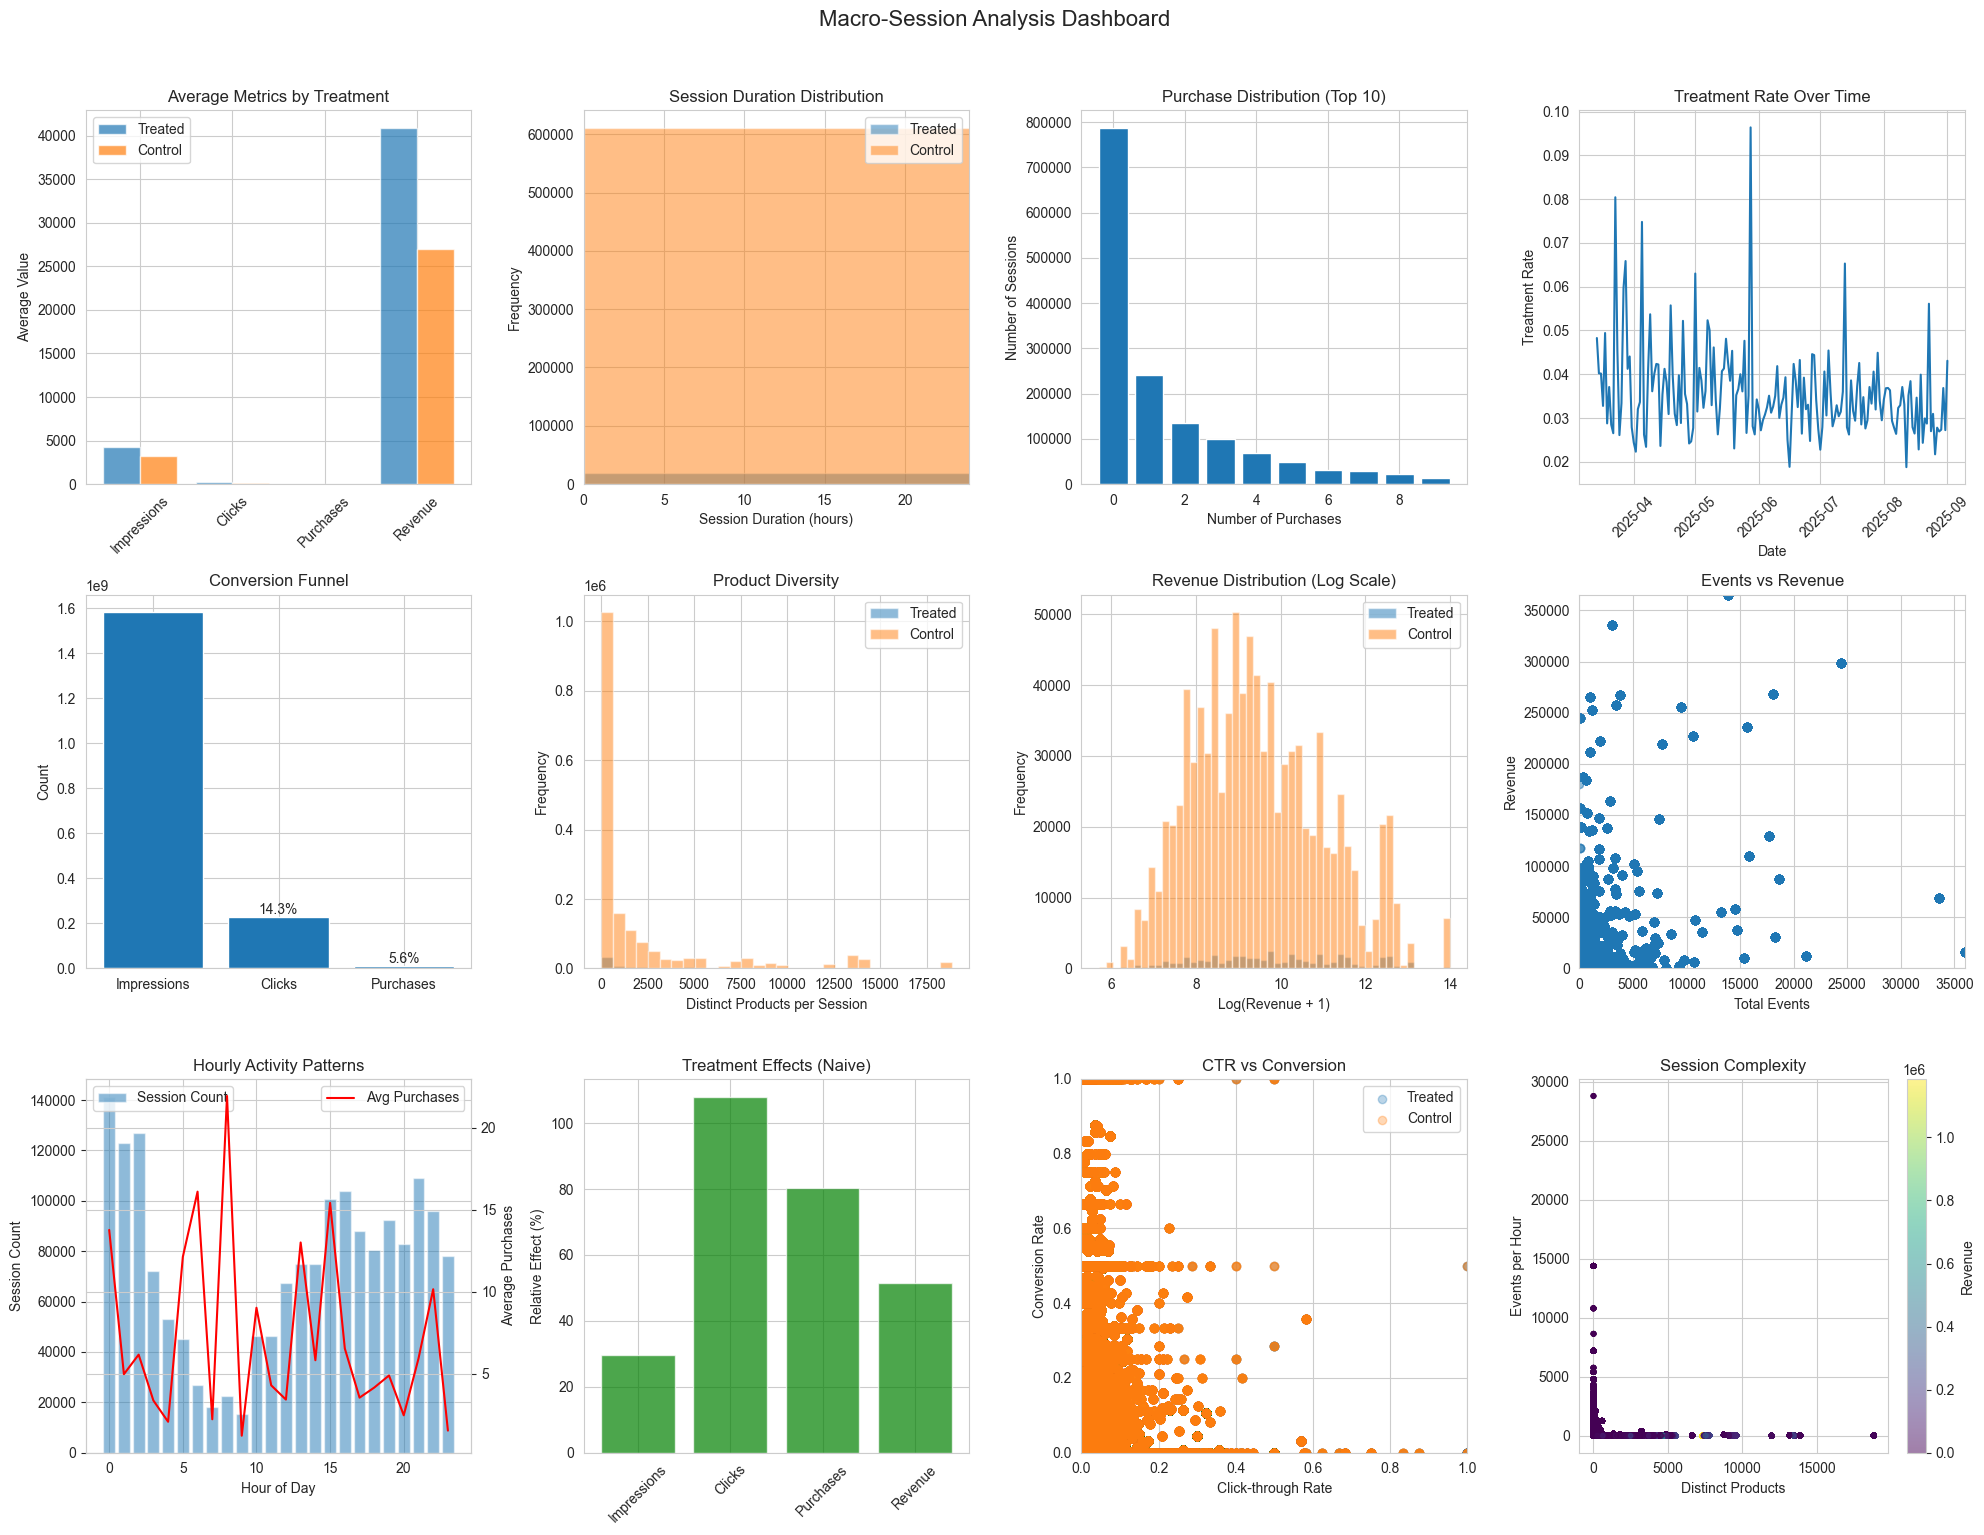


📊 Visualization Summary:
- Total sessions analyzed: 1,786,179
- Treatment rate: 3.8%
- Average session duration: 738.66 hours
- Sessions with purchases: 56.0%
- Average revenue per session: $27498.92


In [91]:
### Visualization Dashboard

# Create comprehensive visualizations
fig, axes = plt.subplots(3, 4, figsize=(20, 15))
fig.suptitle('Macro-Session Analysis Dashboard', fontsize=16, y=1.02)

# 1. Session Metrics Distribution
ax = axes[0, 0]
metrics = ['total_impressions', 'total_clicks', 'total_purchases', 'total_revenue']
metric_labels = ['Impressions', 'Clicks', 'Purchases', 'Revenue']
treated_means = [panel.filter(pl.col('treated').cast(pl.Boolean)).select(m).mean().item() for m in metrics]
control_means = [panel.filter(~pl.col('treated').cast(pl.Boolean)).select(m).mean().item() for m in metrics]
x = np.arange(len(metrics))
ax.bar(x - 0.2, treated_means, 0.4, label='Treated', alpha=0.7)
ax.bar(x + 0.2, control_means, 0.4, label='Control', alpha=0.7)
ax.set_xticks(x)
ax.set_xticklabels(metric_labels, rotation=45)
ax.set_title('Average Metrics by Treatment')
ax.legend()
ax.set_ylabel('Average Value')

# 2. Session Length Distribution
ax = axes[0, 1]
for treated_val in [1, 0]:
    data = panel.filter(pl.col('treated') == treated_val)['session_duration_hours'].to_numpy()
    ax.hist(data, bins=50, alpha=0.5, label=f"{'Treated' if treated_val else 'Control'}")
ax.set_xlabel('Session Duration (hours)')
ax.set_ylabel('Frequency')
ax.set_title('Session Duration Distribution')
ax.legend()
ax.set_xlim(0, 24)

# 3. Purchase Patterns
ax = axes[0, 2]
purchase_dist = panel.group_by('total_purchases').agg(pl.count().alias('count'))
purchase_dist = purchase_dist.sort('total_purchases')
ax.bar(purchase_dist['total_purchases'][:10], purchase_dist['count'][:10])
ax.set_xlabel('Number of Purchases')
ax.set_ylabel('Number of Sessions')
ax.set_title('Purchase Distribution (Top 10)')

# 4. Treatment Balance Over Time
ax = axes[0, 3]
daily_treatment = panel.group_by(pl.col('session_start').dt.date()).agg([
    pl.col('treated').cast(pl.Int64).sum().alias('treated_count'),
    pl.count().alias('total_count')
])
daily_treatment = daily_treatment.with_columns(
    (pl.col('treated_count') / pl.col('total_count')).alias('treatment_rate')
)
daily_treatment = daily_treatment.sort('session_start')
ax.plot(daily_treatment['session_start'], daily_treatment['treatment_rate'])
ax.set_xlabel('Date')
ax.set_ylabel('Treatment Rate')
ax.set_title('Treatment Rate Over Time')
ax.tick_params(axis='x', rotation=45)

# 5. Funnel Conversion (Session Level)
ax = axes[1, 0]
funnel_data = panel.select([
    pl.col('total_impressions').sum(),
    pl.col('total_clicks').sum(),
    pl.col('total_purchases').sum()
]).to_numpy()[0]
stages = ['Impressions', 'Clicks', 'Purchases']
ax.bar(stages, funnel_data)
for i, v in enumerate(funnel_data):
    if i > 0:
        conversion = (funnel_data[i] / funnel_data[i-1]) * 100
        ax.text(i, v, f'{conversion:.1f}%', ha='center', va='bottom')
ax.set_ylabel('Count')
ax.set_title('Conversion Funnel')

# 6. Product Diversity
ax = axes[1, 1]
for treated_val in [1, 0]:
    data = panel.filter(pl.col('treated') == treated_val)['distinct_products'].to_numpy()
    ax.hist(data, bins=30, alpha=0.5, label=f"{'Treated' if treated_val else 'Control'}")
ax.set_xlabel('Distinct Products per Session')
ax.set_ylabel('Frequency')
ax.set_title('Product Diversity')
ax.legend()

# 7. Revenue Distribution
ax = axes[1, 2]
for treated_val in [1, 0]:
    data = panel.filter(pl.col('treated') == treated_val)
    revenue = data.filter(pl.col('total_revenue') > 0)['total_revenue'].to_numpy()
    if len(revenue) > 0:
        ax.hist(np.log1p(revenue), bins=50, alpha=0.5,
                label=f"{'Treated' if treated_val else 'Control'}")
ax.set_xlabel('Log(Revenue + 1)')
ax.set_ylabel('Frequency')
ax.set_title('Revenue Distribution (Log Scale)')
ax.legend()

# 8. Event Intensity
ax = axes[1, 3]
total_events = panel.select(
    (pl.col('total_impressions') + pl.col('total_clicks') + pl.col('total_purchases')).alias('total_events')
)['total_events']
ax.scatter(total_events.to_numpy(), panel['total_revenue'].to_numpy(), alpha=0.1)
ax.set_xlabel('Total Events')
ax.set_ylabel('Revenue')
ax.set_title('Events vs Revenue')
ax.set_xlim(0, total_events.quantile(0.99))
ax.set_ylim(0, panel['total_revenue'].quantile(0.99))

# 9. Hourly Patterns
ax = axes[2, 0]
hourly = panel.group_by(pl.col('session_start').dt.hour()).agg([
    pl.col('total_purchases').mean().alias('avg_purchases'),
    pl.count().alias('session_count')
])
hourly = hourly.sort('session_start')
ax2 = ax.twinx()
ax.bar(hourly['session_start'], hourly['session_count'], alpha=0.5, label='Session Count')
ax2.plot(hourly['session_start'], hourly['avg_purchases'], 'r-', label='Avg Purchases')
ax.set_xlabel('Hour of Day')
ax.set_ylabel('Session Count')
ax2.set_ylabel('Average Purchases')
ax.set_title('Hourly Activity Patterns')
ax.legend(loc='upper left')
ax2.legend(loc='upper right')

# 10. Treatment Effect Preview
ax = axes[2, 1]
treated_data = panel.filter(pl.col('treated').cast(pl.Boolean))
control_data = panel.filter(~pl.col('treated').cast(pl.Boolean))
metrics = ['total_impressions', 'total_clicks', 'total_purchases', 'total_revenue']
metric_labels = ['Impressions', 'Clicks', 'Purchases', 'Revenue']
effects = []
for metric in metrics:
    treated_mean = treated_data[metric].mean()
    control_mean = control_data[metric].mean()
    effect = ((treated_mean - control_mean) / control_mean * 100) if control_mean > 0 else 0
    effects.append(effect)
colors = ['green' if e > 0 else 'red' for e in effects]
ax.bar(metric_labels, effects, color=colors, alpha=0.7)
ax.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
ax.set_ylabel('Relative Effect (%)')
ax.set_title('Treatment Effects (Naive)')
ax.tick_params(axis='x', rotation=45)

# 11. Click-through Rates
ax = axes[2, 2]
panel_with_ctr = panel.with_columns([
    (pl.col('total_clicks') / pl.col('total_impressions')).fill_nan(0).alias('ctr'),
    (pl.col('total_purchases') / pl.col('total_clicks')).fill_nan(0).alias('conversion_rate')
])
for treated_val in [1, 0]:
    data = panel_with_ctr.filter(pl.col('treated') == treated_val)
    data = data.filter(pl.col('total_impressions') > 0)
    ax.scatter(data['ctr'].to_numpy(), data['conversion_rate'].to_numpy(),
                alpha=0.3, label=f"{'Treated' if treated_val else 'Control'}")
ax.set_xlabel('Click-through Rate')
ax.set_ylabel('Conversion Rate')
ax.set_title('CTR vs Conversion')
ax.legend()
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)

# 12. Session Complexity
ax = axes[2, 3]
complexity = panel.with_columns([
    pl.col('distinct_products').alias('products'),
    ((pl.col('total_impressions') + pl.col('total_clicks') + pl.col('total_purchases')) /
    pl.col('session_duration_hours')).alias('event_rate')
])
scatter = ax.scatter(complexity['products'].to_numpy(),
                    complexity['event_rate'].to_numpy(),
                    c=panel['total_revenue'].to_numpy(),
                    cmap='viridis', alpha=0.5, s=10)
ax.set_xlabel('Distinct Products')
ax.set_ylabel('Events per Hour')
ax.set_title('Session Complexity')
plt.colorbar(scatter, ax=ax, label='Revenue')

plt.tight_layout()
plt.show()

print("\n📊 Visualization Summary:")
print(f"- Total sessions analyzed: {panel.height:,}")
print(f"- Treatment rate: {panel['treated'].cast(pl.Boolean).mean():.1%}")
print(f"- Average session duration: {panel['session_duration_hours'].mean():.2f} hours")
print(f"- Sessions with purchases: {(panel['total_purchases'] > 0).mean():.1%}")
print(f"- Average revenue per session: ${panel['total_revenue'].mean():.2f}")


In [92]:
print("\n--- Refining Final Dataset Columns ---")

# Define the exact columns we want in the final dataset
# Organized by category for clarity

FINAL_COLUMNS = [
    # === IDENTIFIERS ===
    'macro_session_id',     # Unique session identifier
    'product_id',          # Product identifier
    'vendor_id',           # Vendor/advertiser identifier
    'user_id',             # User identifier
    
    # === SESSION METADATA ===
    'session_start',       # Session start timestamp
    'session_end',         # Session end timestamp
    'session_has_purchase', # Binary: did session contain any purchase
    'session_duration_hours', # Original session duration
    'duration_winsorized',  # Winsorized duration for modeling
    
    # === PRODUCT-LEVEL METRICS (Treatment & Outcomes) ===
    'impressions_on_product',  # Count of impressions for this product
    'clicks_on_product',       # Count of clicks on this product
    'purchases_on_product',    # Count of purchases of this product
    'revenue_from_product',    # Revenue from this product (in cents)
    
    # === SESSION-LEVEL METRICS ===
    'total_impressions',   # Total impressions in session
    'total_clicks',        # Total clicks in session
    'total_purchases',     # Total purchases in session
    'total_revenue',       # Total revenue in session (in cents)
    'distinct_products',   # Number of unique products viewed
    'distinct_vendors',    # Number of unique vendors shown
    
    # === SESSION INTENSITY CONTROLS ===
    'events_per_hour',         # Event rate during session
    'products_per_hour',       # Product browsing rate
    'vendors_per_hour',        # Vendor diversity rate
    'session_intensity_score', # Composite intensity measure (0-1)
    'is_high_intensity',       # Binary: above median intensity
    'is_very_high_intensity',  # Binary: above 75th percentile intensity
    'is_long_session',         # Binary: session > 24 hours
    'is_multiday_session',     # Binary: session > 72 hours
    'log_events_per_hour',     # Log-transformed event rate
    'log_products_per_hour',   # Log-transformed product rate
    
    # === PRIOR HISTORY FEATURES ===
    'prior_30d_impressions',   # User's impressions in prior 30 days
    'prior_30d_clicks',        # User's clicks in prior 30 days
    'prior_30d_purchases',     # User's purchases in prior 30 days
    'prior_30d_events',        # User's total events in prior 30 days
    
    # === TREATMENT & OUTCOME VARIABLES ===
    'treated',             # Binary: product was clicked (treatment)
    'purchased',           # Binary: product was purchased (outcome)
    'actual_revenue',      # Revenue from product (0 if not purchased)
    
    # === FIXED EFFECTS IDENTIFIERS ===
    'week',                # Week of session start
    'year',                # Year of session start
    'year_week',           # Combined year-week for FE
    
    # === PRODUCT CATALOG FEATURES ===
    'catalog_price',       # Listed price from catalog (in cents)
    'brand',               # Brand identifier
    'department_id',       # Department category
    'category_id',         # Specific category
    'price',               # Cleaned price (median-filled)
    
    # === LOG TRANSFORMATIONS ===
    'log_price',           # Log(price + 1)
    'log_revenue',         # Log(actual_revenue + 1)
    'log_duration',        # Log(duration + 1)
    
    # === ADDITIONAL FLAGS ===
    'is_abandoned',        # Binary: session ended without purchase
    'had_impression',      # Binary: product had impression
    'had_click'           # Binary: product had click
]

# Check which columns exist in the panel
existing_columns = set(panel.columns)
requested_columns = set(FINAL_COLUMNS)
missing_columns = requested_columns - existing_columns
extra_columns = existing_columns - requested_columns

if missing_columns:
    print(f"\nWARNING: {len(missing_columns)} requested columns not found in panel:")
    for col in sorted(missing_columns):
        print(f"  - {col}")

if extra_columns:
    print(f"\nINFO: {len(extra_columns)} columns will be dropped:")
    for col in sorted(extra_columns)[:10]:  # Show first 10
        print(f"  - {col}")
    if len(extra_columns) > 10:
        print(f"  ... and {len(extra_columns) - 10} more")

# Select only the columns that exist
columns_to_keep = [col for col in FINAL_COLUMNS if col in panel.columns]
panel = panel.select(columns_to_keep)

print(f"\n✓ Final dataset refined to {len(columns_to_keep)} columns")

# Verify treatment variable is clearly defined
treated_mean = panel['treated'].mean()
print(f"\nTreatment definition verification:")
print(f"  'treated' = 1 if clicks_on_product > 0")
print(f"  Treatment rate: {treated_mean:.2%}")

# Final data quality check
print("\nFinal data quality check:")
critical_cols = ['macro_session_id', 'product_id', 'user_id', 'treated', 'purchased']
for col in critical_cols:
    null_count = panel[col].null_count()
    print(f"  {col}: {null_count} nulls")

print(f"\n✓ Dataset ready for modeling with {panel.height:,} observations")


--- Refining Final Dataset Columns ---

✓ Final dataset refined to 50 columns

Treatment definition verification:
  'treated' = 1 if clicks_on_product > 0
  Treatment rate: 3.77%

Final data quality check:
  macro_session_id: 0 nulls
  product_id: 0 nulls
  user_id: 0 nulls
  treated: 0 nulls
  purchased: 0 nulls

✓ Dataset ready for modeling with 1,786,179 observations


In [93]:
# Save the dataset
print("\n--- Saving Final Dataset ---")

panel.write_parquet(OUTPUT_FILE)
print(f"✓ Saved to {OUTPUT_FILE}")
print(f"  File size: {OUTPUT_FILE.stat().st_size / (1024**2):.2f} MB")

# Create comprehensive data dictionary
data_dictionary = {
    # === IDENTIFIERS ===
    'macro_session_id': 'Unique identifier for a single user shopping episode defined by 3-day inactivity gap',
    'product_id': 'Unique product identifier',
    'vendor_id': 'Advertiser/vendor identifier for the product',
    'user_id': 'Anonymized user identifier',
    
    # === SESSION METADATA ===
    'session_start': 'Timestamp when the session began',
    'session_end': 'Timestamp when the session ended',
    'session_has_purchase': 'Binary indicator if session contains any purchase',
    'session_duration_hours': 'Length of session in hours (original, may contain outliers)',
    'duration_winsorized': 'Session duration capped at 99th percentile for modeling stability',
    
    # === PRODUCT-LEVEL METRICS ===
    'impressions_on_product': 'Count of impressions for this specific product in this session',
    'clicks_on_product': 'Count of clicks on this specific product in this session (multiple clicks per ad possible)',
    'purchases_on_product': 'Count of purchases of this specific product in this session',
    'revenue_from_product': 'Total revenue from this specific product in this session (in cents, divide by 100 for dollars)',
    
    # === SESSION-LEVEL METRICS ===
    'total_impressions': 'Total impressions across all products in this session',
    'total_clicks': 'Total clicks across all products in this session',
    'total_purchases': 'Total purchases across all products in this session',
    'total_revenue': 'Total revenue across all products in this session (in cents)',
    'distinct_products': 'Number of unique products interacted with in this session',
    'distinct_vendors': 'Number of unique vendors whose products were shown in this session',
    
    # === SESSION INTENSITY CONTROLS ===
    'events_per_hour': 'Rate of user activity (impressions + clicks + purchases) per hour during session',
    'products_per_hour': 'Rate of unique products viewed per hour during session',
    'vendors_per_hour': 'Rate of unique vendors encountered per hour during session',
    'session_intensity_score': 'Composite intensity measure normalized to 0-1 range (higher = more intense)',
    'is_high_intensity': 'Binary flag: 1 if session event rate is above median',
    'is_very_high_intensity': 'Binary flag: 1 if session event rate is above 75th percentile',
    'is_long_session': 'Binary flag: 1 if session duration exceeds 24 hours',
    'is_multiday_session': 'Binary flag: 1 if session duration exceeds 72 hours',
    'log_events_per_hour': 'Natural log of (events_per_hour + 1) for modeling',
    'log_products_per_hour': 'Natural log of (products_per_hour + 1) for modeling',
    
    # === PRIOR HISTORY FEATURES ===
    'prior_30d_impressions': 'Count of impressions by this user in the 30 days before session start',
    'prior_30d_clicks': 'Count of clicks by this user in the 30 days before session start',
    'prior_30d_purchases': 'Count of purchases by this user in the 30 days before session start',
    'prior_30d_events': 'Total event count by this user in the 30 days before session start',
    
    # === TREATMENT & OUTCOME VARIABLES ===
    'treated': 'Binary (1/0) treatment indicator: 1 if product was clicked in this session',
    'purchased': 'Binary (1/0) outcome: 1 if this product was purchased in this session',
    'actual_revenue': 'Revenue from this product in this session in cents (0 if not purchased)',
    
    # === FIXED EFFECTS IDENTIFIERS ===
    'week': 'Week number of session start (for week fixed effects)',
    'year': 'Year of session start',
    'year_week': 'Combined year_week identifier for time fixed effects',
    
    # === PRODUCT CATALOG FEATURES ===
    'catalog_price': 'Listed price of product from catalog (in cents)',
    'brand': 'Brand identifier for the product',
    'department_id': 'Department category for the product',
    'category_id': 'Specific category identifier for the product',
    'price': 'Cleaned catalog price with median imputation for missing values (in cents)',
    
    # === LOG TRANSFORMATIONS ===
    'log_price': 'Natural log of (price + 1) for modeling',
    'log_revenue': 'Natural log of (actual_revenue + 1) for modeling',
    'log_duration': 'Natural log of (session_duration_hours + 1) for modeling',
    
    # === ADDITIONAL FLAGS ===
    'is_abandoned': 'Binary (1/0) flag: 1 if session ended without any purchase',
    'had_impression': 'Binary flag: 1 if product had at least one impression in session',
    'had_click': 'Binary flag: 1 if product had at least one click in session'
}

# Create metadata with data dictionary
data_dict = {
    'generated_at': datetime.now().isoformat(),
    'shape': {'rows': panel.height, 'columns': panel.width},
    'parameters': {
        'session_gap_days': SESSION_GAP_DAYS,
        'prior_user_history_days': PRIOR_USER_HISTORY_DAYS,
        'winsorize_percentile': WINSORIZE_PERCENTILE
    },
    'columns': {
        col: str(panel[col].dtype) for col in panel.columns
    },
    'data_dictionary': data_dictionary,
    'statistics': {
        'n_sessions': panel['macro_session_id'].n_unique(),
        'n_products': panel['product_id'].n_unique(),
        'n_users': panel['user_id'].n_unique(),
        'n_vendors': panel['vendor_id'].n_unique(),
        'treatment_rate': float(panel['treated'].mean()) if 'treated' in panel.columns else None,
        'purchase_rate': float(panel['purchased'].mean()) if 'purchased' in panel.columns else None,
        'avg_session_intensity': float(panel['session_intensity_score'].mean()) if 'session_intensity_score' in panel.columns else None,
        'pct_high_intensity': float(panel['is_high_intensity'].mean() * 100) if 'is_high_intensity' in panel.columns else None
    }
}

dict_path = METADATA_FILE
with open(dict_path, 'w') as f:
    json.dump(data_dict, f, indent=2)
print(f"✓ Saved metadata with comprehensive data dictionary to {dict_path}")

# Calculate runtime
end_time = datetime.now()
runtime = end_time - start_time
print(f"\n" + "="*80)
print(f"MACRO-SESSION PANEL CREATION COMPLETE")
print(f"Total runtime: {runtime}")
print(f"\nDataset includes {len(data_dictionary)} well-documented features")
print(f"Session intensity controls added to isolate causal effects")
print(f"Ready for fixed effects modeling in 07_fixed_effects.ipynb")
print("="*80)


--- Saving Final Dataset ---
✓ Saved to data/analytical_panel_dataset.parquet
  File size: 125.25 MB
✓ Saved metadata with comprehensive data dictionary to data/analytical_panel_metadata.json

MACRO-SESSION PANEL CREATION COMPLETE
Total runtime: 0:00:47.304508

Dataset includes 50 well-documented features
Session intensity controls added to isolate causal effects
Ready for fixed effects modeling in 07_fixed_effects.ipynb
